In [247]:

from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import wikipedia
from urllib.request import urlopen
import json
import re
api = "https://www.googleapis.com/books/v1/volumes?q=title:"
isbnAPI = "https://www.googleapis.com/books/v1/volumes?q=isbn:"


## Big idea- Using wikipedia pages to infer ethnicity
Keywords and permulations
- taking the associated catagories that are used, and using nltk's wordnet to find all associated words
Searching
- opening up the author's wikipedia article, and searching for the frequencies of all the keywords. At the end of the search, whichever catagory has the most mentions, is the catagory the author is sorted into
- if there are no mentions, check the author's birthplace and parse that
- if no birthplace, people assume whiteness inherently when writting, so the same must be done. That OR the prediction thing

In [249]:
def getBookInfo(title):
    title = title.replace(' ', '%')
    url = api + title
    response = urlopen(url)
    data = json.loads(response.read())
    return data

In [250]:
title = ['How to Invent Everything','Percy Jackson','Oxford English Dictionary','The Fault in Our Stars','The Alchemist','The Hunger Games','To Kill a Mockingbird','The Kite Runner','0994047134','Fifteen Hundred Miles from the Sun']
books = pd.read_csv('books.csv',on_bad_lines='skip')
title = books['title'].to_list()[-1000:]
namesDF = pd.DataFrame()
for bookTitle in title:
    try:
        bookInfo = getBookInfo(bookTitle)['items'][0]['volumeInfo']
        isbn13 = bookInfo['industryIdentifiers'][0]['identifier']
        author = bookInfo['authors'][0].split(' ')
        lastName = author[-1]
        firstName = author[0]
        name = firstName + ' ' + lastName
        # Taking the first result for the search query which is index 0, getting information about the book and then printing the author of the book.
        namesDF = namesDF.append({'isbn':isbn13,'Title':bookInfo['title'],'author' : name, 'last':lastName,'first': firstName},ignore_index=True)
    except Exception as inst:
        continue
namesDF

,isbn,Title,author,last,first
0,9780307777812,Theodore Rex,Edmund Morris,Morris,Edmund
1,1090353472,Oedipus Rex Or Oedipus the King: (annotated) (...,Sophocles Sophocles,Sophocles,Sophocles
2,9780307777829,The Rise of Theodore Roosevelt,Edmund Morris,Morris,Edmund
3,9780812967883,The Scientists,John Gribbin,Gribbin,John
4,9781135564001,"A History of the Life Sciences, Revised and Ex...",Lois Magner,Magner,Lois
...,...,...,...,...,...
879,1560254416,Expelled from Eden,Perseus Perseus,Perseus,Perseus
880,UOM:39015015233664,You Bright and Risen Angels,William Vollmann,Vollmann,William
881,9780307433848,The Book Thief,Markus Zusak,Zusak,Markus
882,1856499596,In the Name of the Poor,Neil Webster,Webster,Neil


In [251]:
wikiPages = []
for i,author in enumerate(namesDF['author']):
    
    page_object =[]
    bookTitle= namesDF['Title'][i]
    bookTitle = bookTitle.split(',')[0]
    titleSplitter = bookTitle.split(' ')
    if titleSplitter[0] == 'The':
        bookTitle = bookTitle[4:]
    bookTitle = re.sub(r"\([^()]*\)", "", bookTitle)
    # remove anything in parentheses
    # The word 'the' may be lowercased on wikipedia, so if it is even there, its easier to just remove it.
    try:
        page_object = wikipedia.page(wikipedia.search(author)[0])
    except Exception as inst:
        try:
            try:
                temp_object = wikipedia.page(author + ' (author)')
                arr =str(temp_object.title).split(' ')
                nameCheck = (namesDF['first'][i] in arr) and (namesDF['last'][i] in arr)
                if nameCheck==False:
                    raise Exception('Name not found')
                elif (temp_object.content.find(bookTitle) != -1):
                    page_object = temp_object
            except Exception as e:
                print(e)
                # wikiPages.append('NaN')
                # continue
            # This line?
            # Checks if out of the list of pages,  if the author flag helps identify the author page
        except Exception as e:
            searches = wikipedia.search(author)[1:]            
            for search in (searches):
                # goes through every suggested search result, checks for the authors full name, and checks if the book title is mentioned somewhere

                # if the first and last names aren't in any of the searches, it will throw an error.
                arr = str(search).split(' ')
                nameCheck = (namesDF['first'][i] in arr) and (namesDF['last'][i] in arr)
                # check if both the first, and last name are i the search
                if nameCheck:
                    temp_object = wikipedia.page(search)
                    
                    if(temp_object.content.find(bookTitle) != -1):
                        
                        page_object = temp_object
                        # checks if the page is about the author
                        break
    if(page_object==[]):
        wikiPages.append('NaN')
        continue
    else:
        wikiPages.append(page_object)
namesDF['wikiPage'] = wikiPages
namesDF


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Name not found
Name not found
Name not found
Page id "lindsay boyer author" does not match any pages. Try another id!
Page id "healing becker author" does not match any pages. Try another id!
Page id "harold live at author" does not match any pages. Try another id!
Name not found
Name not found
Name not found
Name not found
Name not found
Name not found
Name not found
Page id "ralf bonsack author" does not match any pages. Try another id!
Name not found
"Lauren Henderson" may refer to: 
Lauren Henderson (singer)
Lauren Henderson (writer)
Name not found
Name not found
Name not found
Name not found
Name not found
Name not found
"Kenneth Thompson" may refer to: 
Kenneth Thompson (bishop)
Kenneth Thompson (ice hockey)
Kenneth P. Thompson
Kenneth W. Thompson
G. Kennedy Thompson
Ken Thompson (footballer, born 1926)
Ken Thompson (footballer, born 1945)
Ken Thompson
Kenan Thompson
Kenny Thompson (Bermudian footballer)
Kenny Thompson
Sir Kenneth Thompson, 1st Baronet
Kenneth Kwamina Thompson
Ke

,isbn,Title,author,last,first,wikiPage
0,9780307777812,Theodore Rex,Edmund Morris,Morris,Edmund,<WikipediaPage 'Edmund Morris (writer)'>
1,1090353472,Oedipus Rex Or Oedipus the King: (annotated) (...,Sophocles Sophocles,Sophocles,Sophocles,<WikipediaPage 'Sophocles'>
2,9780307777829,The Rise of Theodore Roosevelt,Edmund Morris,Morris,Edmund,<WikipediaPage 'Edmund Morris (writer)'>
3,9780812967883,The Scientists,John Gribbin,Gribbin,John,<WikipediaPage 'John Gribbin'>
4,9781135564001,"A History of the Life Sciences, Revised and Ex...",Lois Magner,Magner,Lois,<WikipediaPage 'Ligature (medicine)'>
...,...,...,...,...,...,...
879,1560254416,Expelled from Eden,Perseus Perseus,Perseus,Perseus,<WikipediaPage 'Perseus'>
880,UOM:39015015233664,You Bright and Risen Angels,William Vollmann,Vollmann,William,<WikipediaPage 'William T. Vollmann'>
881,9780307433848,The Book Thief,Markus Zusak,Zusak,Markus,<WikipediaPage 'Markus Zusak'>
882,1856499596,In the Name of the Poor,Neil Webster,Webster,Neil,"<WikipediaPage 'Andy Webster (footballer, born..."


In [252]:
print(len(namesDF['author']))
for index,page in namesDF.loc[namesDF['wikiPage'] == 'NaN'].iterrows():
    try:
        webpage = wikipedia.page(page[1])
        links = list(webpage.links)
        # check if the last name is anywhere in the page links
        for i in range(len(links)):

            lastname = page[3]

            if(lastname in str(links[i]).split(' ')):
                namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+links[i]+'\"'))
            # if any(page[4] in word for word in links):
            #     print('found')
    except Exception as e:
        try:
            webpage = wikipedia.page("\""+page[1]+'\"')
            links = list(webpage.links)
            pingedLinks = []
            # check if the last name is anywhere in the page links
            for i in range(len(links)):

                lastname = page[3]
                
                if(lastname in str(links[i]).split(' ')):
                    pingedLinks.append(links[i])


            j = len(pingedLinks[0])
            winner = pingedLinks[0]
            if len(pingedLinks)>1:
                # if there are multiple links with the Author's last name, pick the one with the least characters.
                # I decided on this cause sometimes if an author is super prolific, a possestion they have may have an article aswell 
                    for k in pingedLinks:
                        if len(k)<j:
                            j = len(k)
                            winner = k
                    if(lastname in str(wikipedia.page("\""+winner+'\"').title).split(' ')):
                        print(namesDF.at[index,'wikiPage'])
                        namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+winner+'\"'))
                        
                        
                    # find the one with teh least words

            elif(lastname in str(wikipedia.page("\""+winner+'\"').title).split(' ')):
                print(namesDF.at[index,'wikiPage'])
                namesDF.at[index,'wikiPage'] = (wikipedia.page("\""+links[i]+'\"'))
                
            else: 
                raise Exception('Name not found')
        except Exception as e:
            print(e)
            continue
namesDF.loc[namesDF['wikiPage'] == 'NaN']

884
Page id ""No Cherubs for Melanie"" does not match any pages. Try another id!
Page id ""The Everything Keto Diet Meal Prep Cookbook"" does not match any pages. Try another id!
Page id ""The Mammoth Book of Storms, Shipwrecks and Sea Disasters"" does not match any pages. Try another id!
list index out of range


C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\amer_\AppData\Local\Programs\Python\Python39\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


list index out of range
NaN
Page id ""NINCDS Index to Research Grants & Contracts"" does not match any pages. Try another id!
Page id ""CliffsNotes on Hemingway's The Sun Also Rises"" does not match any pages. Try another id!
Page id ""Mission Possible: Go Create a Life That Counts"" does not match any pages. Try another id!
list index out of range
Page id ""The Girls of Lighthouse Lane #4"" does not match any pages. Try another id!
Page id ""The Girls of Lighthouse Lane #3"" does not match any pages. Try another id!
list index out of range
list index out of range
Page id ""The Myron Bolitar Series 7-Book Bundle"" does not match any pages. Try another id!
list index out of range
list index out of range
"Brian Hall" may refer to: 
Brian Hall (actor)
Brian Hall (author)
Brian Hall (Yorkshire cricketer)
Brian Hall (Worcestershire cricketer)
Brian Hall (Bermudian cricketer)
Brian Hall (footballer, born 1946)
Brian Hall (footballer, born 1939)
Brian Hall (Australian footballer)
Brian Hall (

,isbn,Title,author,last,first,wikiPage
12,075286663X,The Best American Mystery Stories 4,Michael Connelly,Connelly,Michael,NaN
15,1554885833,No Cherubs for Melanie,James Hawkins,Hawkins,James,NaN
17,9781780334547,Street of the Five Moons,Elizabeth Peters,Peters,Elizabeth,NaN
60,9781507210468,The Everything Keto Diet Meal Prep Cookbook,Lindsay Boyers,Boyers,Lindsay,NaN
71,9781732191136,Flirting with Forever,Kendall Ryan,Ryan,Kendall,NaN
...,...,...,...,...,...,...
844,9780593158807,The Kitchen Front,Jennifer Ryan,Ryan,Jennifer,NaN
863,9780061846977,Die Broke,Stephen Pollan,Pollan,Stephen,NaN
864,1594860165,"Live Rich, Die Broke",Stephen Pollan,Pollan,Stephen,NaN
865,9780062048158,The Die Broke Financial Problem Solver,Stephen Pollan,Pollan,Stephen,NaN


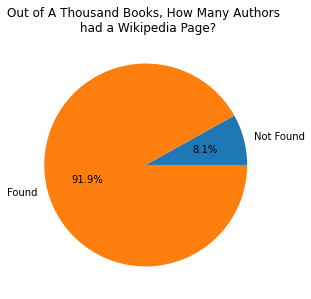

In [253]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.pie([len(namesDF.loc[namesDF['wikiPage'] == 'NaN']),len(namesDF)],labels = ['Not Found','Found'], autopct='%1.1f%%')
plt.title('Out of A Thousand Books, How Many Authors \n had a Wikipedia Page?')

fig.set_facecolor('White')

In [255]:
namesDF.to_csv('namesDF.csv')

In [254]:
title = '9781417732470'
url = isbnAPI + title
response = urlopen(url)
data = json.loads(response.read())
data['items'][0]['volumeInfo']['authors']


['Rick Riordan']

## What might be worthwhile until I can get the library books, is a random book selector. That way I can see how efficient the code is
https://www.generatormix.com/random-book-generator
https://www.bestrandoms.com/random-book-generator

Notes
- if the isbn lookup doesnt work, then try the title lookup
    - The google books isbn api is small, try to get access to another
- Some authors don't have a wikipedia page, so we need to search for them
- Maybe if they lack a wiki article, THEN do the name search? I dunnoooooo


## Ethnicity Guessing

In [371]:

asian = np.asarray(['china','japan','korea','taiwan','east-asian','japanese','korean','chinese','taiwanese','india','pakistan','bangledesh','nepal','south-asian','hindi','urdu','afghanistan','afghani','central asian','middle eastern','mongonlia','mongolian'])
black = np.asarray(['african-american','black bodies','nigera','racism','ethiopia','egypt','african','nigerian','ethiopian','egyptian','NAACP','black man','black woman','black american'])
# black != african, but african is a subset of black.
white = np.asarray(['european','caucasian'])
hispanic = np.asarray(['hispanic','mexico','spanish','Latino','Latin'])
keywords = np.asarray([asian,black,white,hispanic])
keywordTitles = ['asian','black','white','hispanic']
for j in range(len(keywords)):
    for i in range(len(keywords[j])):
        for ss in wn.synsets(keywords[j][i]):
            keywords[j] = np.append(keywords[j],np.asarray(ss.lemma_names()),axis = None)
    keywords[j].flatten()
    keywords[j] = list(np.unique(keywords[j]))

keywordDF = (pd.DataFrame(keywords).T)

keywordDF.columns =keywordTitles
keysi = [[],[],[],[]]
for i,key in enumerate(keywords):
    # sort the word list from longest to shortest
    key.sort(key=len, reverse=True)
    for j,word in enumerate(key):
        if(len(word)>3):
            word = word.lower()
            word = word.replace('-',' ')
            wordi = word.replace('_',' ')
            wordi = ' ' + wordi + ' '

            keysi[i].append(wordi)
    keysi[i] = list(set(keysi[i]))

    keysi[i].sort(key=len, reverse=True)
keysi[2].pop(6)
print(keysi)
# THIS CODE IS DISGUSTING PLEASE FIX IT LATER WHY DID I DUPLICATE THE LIST THIS CANT SCALEEEE
# keywordDF.set_index(['asian']).apply(pd.Series.explode).reset_index()

[[' islamic republic of pakistan ', ' islamic state of afghanistan ', " people's republic of china ", ' japanese archipelago ', ' nationalist china ', ' republic of china ', ' republic of india ', ' mongolic language ', ' dae han min gook ', ' japanese islands ', ' korean peninsula ', ' kingdom of nepal ', ' communist china ', ' mainland china ', ' middle eastern ', ' west pakistan ', ' central asian ', ' afghanistani ', ' afghanistan ', ' south asian ', ' min dialect ', ' east asian ', ' bangledesh ', ' hokkianese ', ' fukkianese ', ' nipponese ', ' mongolian ', ' taiwanese ', ' chinaware ', ' mongonlia ', ' red china ', ' han gook ', ' formosan ', ' japanese ', ' pakistan ', ' mongolic ', ' formosa ', ' afghani ', ' chinese ', ' nippon ', ' fukien ', ' cathay ', ' mongol ', ' pashtu ', ' taiwan ', ' pashto ', ' bharat ', ' korean ', ' hindoo ', ' afghan ', ' hindu ', ' paxto ', ' korea ', ' china ', ' hindi ', ' nihon ', ' japan ', ' india ', ' nepal ', ' urdu ', ' amoy '], [' federa

In [423]:
term = 'Chimamanda Ngozi Adichie'
def raceID(term):
    content = str(wikipedia.page('\"' + term+ '\"').content.lower())
    frequency = {}
    for i,key in enumerate(keysi):
        frequency[keywordTitles[i]] = 0
        # sort the word list from longest to shortest
        for word in key:
            count = int(content.count(word))
            if count > 0:
                frequency[keywordTitles[i]] += int(content.count(word))
            content.replace(word,'')
    print(term + " is probably " + max(frequency,key = frequency.get))
    print(frequency)
    return(max(frequency,key = frequency.get))
# raceID('Anthony Fauci')


AttributeError: 'WikipediaPage' object has no attribute 'json_response'

In [34]:
# importing the module
import requests
import bs4

# URL
URL = "https://en.wikipedia.org/wiki/India"

# sending the request
response = requests.get(URL)

# parsing the response
soup = bs4.BeautifulSoup(response.text, 'html')

# Now, we have paresed HTML with us. I want to get the _motto_ from the wikipedia page.
# Elements structure
# table - class="infobox"
# 3rd tr to get motto

# getting infobox
infobox = soup.find('table', {'class': 'infobox'})

# getting 3rd row element tr
third_tr = infobox.find_all('tr')[2]

# from third_tr we have to find first 'a' element and 'div' element to get required data
first_a = third_tr.div.find('a')
div = third_tr.div.div

# motto
print(first_a)
motto = f"{first_a.text} {div.text[:len(div.text) - 3]}"

# printing the motto
print(motto)

<a href="#cite_note-FOOTNOTENational_Informatics_Centre2005-1">[1]</a>


AttributeError: 'NoneType' object has no attribute 'text'

In [32]:
# importing modules
import requests
from lxml import etree
  
# manually storing desired URL
url='https://en.wikipedia.org/wiki/Delhi_Public_School_Society'
  
# fetching its url through requests module  
req = requests.get(url) 
print(req)
  
store = etree.fromstring(req.text)
  
# this will give Motto portion of above 
# URL's info box of Wikipedia's page
output = store.xpath('//table[@class="infobox vcard"]/tr[th/text()="Motto"]/td/i') 
  
# printing the text portion
print(output)
  

<Response [200]>
[]
